In [1]:
# Francisco Dominguez Mateos
# 25/06/2020
#From:https://roberttlange.github.io/posts/2020/03/blog-post-10/

In [2]:
#!conda install -c pytorch pytorch --yes
#!conda install -c pytorch torchvision --yes
#!conda install -c anaconda seaborn --yes

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import numpy as onp
import jax.numpy as np
from jax import grad, jit, vmap, value_and_grad
from jax import random

In [11]:
# Import some additional JAX and dataloader helpers
from jax.scipy.special import logsumexp
from jax.experimental import optimizers
from jax.experimental import stax
from jax.experimental.stax import (BatchNorm, Conv, Dense, Flatten,
                                   Relu, LogSoftmax)
import torch
from torchvision import datasets, transforms

import time
#from: https://github.com/RobertTLange/code-and-blog/blob/master/04_jax_intro/helpers.py
#!conda install -c anaconda seaborn --yes
from helpers import plot_mnist_examples
from helpers import plot_mnist_performance


In [12]:
# Generate key which is used to generate random numbers
key = random.PRNGKey(1)

In [6]:
# Set the PyTorch Data Loader for the training & test set
batch_size = 100

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./pytorch_data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./pytorch_data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)

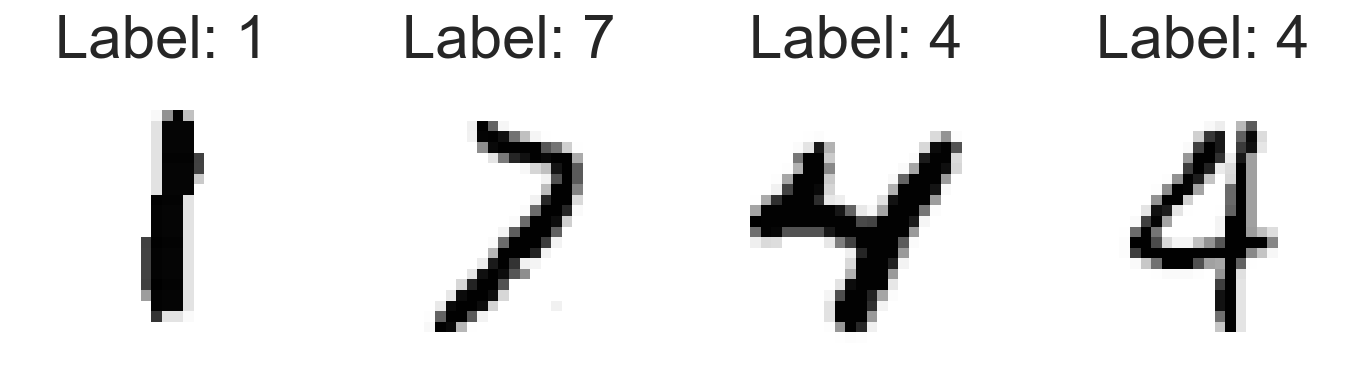

In [7]:
plot_mnist_examples(train_loader)

In [9]:
@jit
def update(params, x, y, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(loss)(params, x, y)
    opt_state = opt_update(0, grads, opt_state)
    return get_params(opt_state), opt_state, value

In [20]:
def run_mnist_training_loop(num_epochs, opt_state, net_type="MLP"):
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    log_acc_train, log_acc_test, train_loss = [], [], []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Get initial accuracy after random init
    train_acc = accuracy(params, train_loader)
    test_acc  = accuracy(params, test_loader)
    log_acc_train.append(train_acc)
    log_acc_test.append(test_acc)

    # Loop over the training epochs
    for epoch in range(num_epochs):
        start_time = time.time()
        for batch_idx, (data, target) in enumerate(train_loader):
            if net_type == "MLP":
                # Flatten the image into 784 vectors for the MLP
                x = np.array(data).reshape(data.size(0), 28*28)
            elif net_type == "CNN":
                # No flattening of the input required for the CNN
                x = np.array(data)
            y = one_hot(np.array(target), num_classes)
            params, opt_state, loss = update(params, x, y, opt_state)
            train_loss.append(loss)

        epoch_time = time.time() - start_time
        train_acc = accuracy(params, train_loader)
        test_acc = accuracy(params, test_loader)
        log_acc_train.append(train_acc)
        log_acc_test.append(test_acc)
        print("Epoch {} | T: {:0.2f} | Train A: {:0.3f} | Test A: {:0.3f}".format(epoch+1, epoch_time,
                                                                    train_acc, test_acc))
    return train_loss, log_acc_train, log_acc_test, opt_state

In [14]:
num_classes = 10
init_fun, conv_net = stax.serial(Conv(32, (5, 5), (2, 2), padding="SAME"),
                                 BatchNorm(), Relu,
                                 Conv(32, (5, 5), (2, 2), padding="SAME"),
                                 BatchNorm(), Relu,
                                 Conv(10, (3, 3), (2, 2), padding="SAME"),
                                 BatchNorm(), Relu,
                                 Conv(10, (3, 3), (2, 2), padding="SAME"), Relu,
                                 Flatten,
                                 Dense(num_classes),
                                 LogSoftmax)

In [15]:
_, params = init_fun(key, (batch_size, 1, 28, 28))

In [16]:
def one_hot(x, k, dtype=np.float32):
    """Create a one-hot encoding of x of size k """
    return np.array(x[:, None] == np.arange(k), dtype)

def accuracy(params, data_loader):
    """ Compute the accuracy for the CNN case (no flattening of input)"""
    acc_total = 0
    for batch_idx, (data, target) in enumerate(data_loader):
        images  = np.array(data)
        targets = one_hot(np.array(target), num_classes)

        target_class    = np.argmax(targets, axis=1)
        predicted_class = np.argmax(conv_net(params, images), axis=1)
        acc_total      += np.sum(predicted_class == target_class)
    return acc_total/len(data_loader.dataset)

def loss(params, images, targets):
    preds = conv_net(params, images)
    return -np.sum(preds * targets)

In [21]:
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)
num_epochs = 2

In [23]:
train_loss, train_log, test_log, opt_state = run_mnist_training_loop(num_epochs,
                                                          opt_state,
                                                          net_type="CNN")

Epoch 1 | T: 9.49 | Train A: 0.984 | Test A: 0.977
Epoch 2 | T: 9.49 | Train A: 0.987 | Test A: 0.979


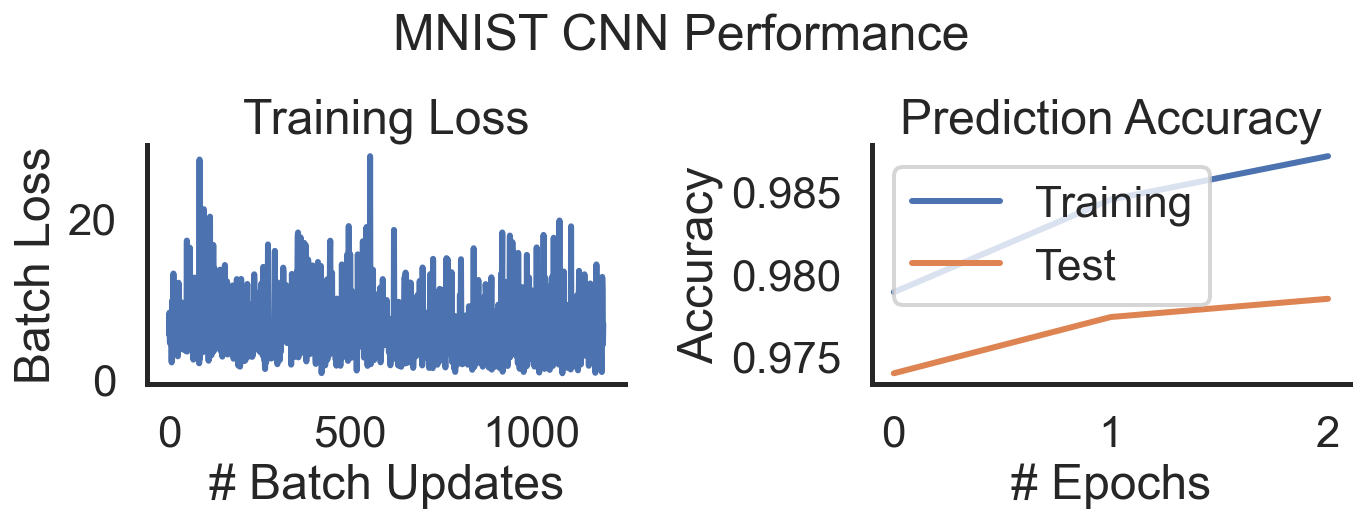

In [24]:
plot_mnist_performance(train_loss, train_log, test_log,
                       "MNIST CNN Performance")